In [87]:
from pathlib import Path
import json

from matplotlib.ticker import AutoMinorLocator
from matplotlib import pyplot as plt
from scipy.stats import gmean
import seaborn as sns
import pandas as pd
import numpy as np
import feather
import lzma

from polya.utils import smooth

work = "jp3"

In [88]:
samples = {
    'mh1': ["Input", "LARP1"],
    'jp3': ['siNC', 'siLARP1-3'],#, 'siLARP44B']
    # 'jp3': ['siNC', 'siLARP44B'],
}[work]

ctrl = {
}.get(work, samples[0])

In [89]:
workdir = Path("/casa/joha/projects/polya/works/")

panels = {
    s: pd.read_msgpack(lzma.open(workdir/work/"tagcounts/{}-single-U-canonical.msgpack.xz".format(s), "rb"))
    for s in samples
} # pd.read_msgpack is deprecated in the >0.25.0 version of pandas

/casa/joha/anaconda3/envs/polya/lib/python3.7/site-packages/pandas/io/packers.py:187: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  unpacked_obj = list(unpack(fh, encoding=encoding, **kwargs))


Get some gene lists

In [90]:
genepath = "/casa/joha/scripts/tailseeker3.1.7/refdb/level3/GRCh38/annotations-gene.feather"
df_gene = feather.read_dataframe(genepath)

# Mitochondrially-encoded genes
df_mtgenes = df_gene[df_gene["seqname"].map(lambda x: x == "chrM" if x else False)]
mtgenes = df_mtgenes["gene_id"]
mtgenes = mtgenes.append(pd.Series(['ENSG00000247627.2', 'ENSG00000248527.1']) ) # adding MTND4P12, MTATP6P1 pseudogenes
print( len(mtgenes), "MT-encoded genes")

# TOP genes: The list is from Yamashita et al., NAR, 2008
topglist = [g.strip().upper() for g in open("../data/external/human_top_genes_nar_2008.csv", "rt").readlines()]
df_topgenes = df_gene[df_gene["gene_name"].isin(topglist)]
topgenes = df_topgenes["gene_id"]
print( len(topgenes), "TOP genes" )

# RP genes
df_rpgenes = df_gene[df_gene["gene_description"].map(lambda x: x.startswith("ribosomal protein") if x else False)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "kinase" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "like" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "binding" not in x)]
print(len(df_rpgenes), "RP genes")
rpgenes = df_rpgenes["gene_id"]

gene_lists = {
    'all': df_gene['gene_id'],
    'mtgenes': mtgenes,
    'topgenes': topgenes,
    'nontopgenes': df_gene['gene_id'][~df_gene['gene_id'].isin(topgenes)],
    'rpgenes': rpgenes,
}

39 MT-encoded genes
89 TOP genes
1177 RP genes


---
### Global poly(A)-tail length distribution

/casa/joha/projects/polya/works/jp3/plots/global_pAlen_dists_jp3_10-220_non-topgenes_wo_mtgenes_mini.pdf saved


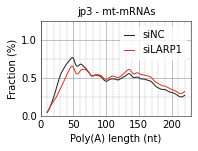

In [94]:
# Configurations
gene_subset = gene_lists['nontopgenes']
subset_label = 'non-topgenes'
drop_subsets=['mtgenes']
# drop_subsets=[]

savefig = True
minifig = True
# figsize = 5.4, 2.8 # for Fig. 4
figsize = 5.4, 3.5 # for Fig. 4

smoothing = True
smoothing_window = 15
pAlen_range = [10, 220]; pr = pAlen_range

styles = ["../polya.mplstyle"]
if minifig is True:
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))
    
with plt.style.context(styles):
    default_colors = sns.color_palette()
    colors_by_smp = json.load(open("../colors_by_smp.json","r"))
    colors = [colors_by_smp.get(smp, default_colors[si]) for si, smp in enumerate(samples)]
    global_fmax = None # Maximum value of the fraction
    
    fig, ax = plt.subplots(figsize=figsize)
    for si, smp in enumerate(samples):
        pn = panels[smp]
        
        # Consider only a specific gene set
        if gene_subset is not None:
            pn = pn.reindex(gene_subset) 

        # Exlucde specific gene sets
        if drop_subsets:
            for subset in drop_subsets:
                pn = pn.drop(gene_lists[subset], errors='ignore')

        if not pAlen_range: pAlen_range = [0, pn.shape[1]-1]

        # Normalization
        pAtags = pn.sum(axis=0).sum(axis=1).iloc[pr[0]:pr[1]+1]
        pAlen_dist = pAtags / pAtags.sum() * 100 # fraction in percent

        # Smoothing
        if smoothing is True:
            pAlen_dist = smooth(np.array(pAlen_dist), window_len=smoothing_window)

        fmax = pAlen_dist.max()
        if global_fmax is None: global_fmax = fmax
        elif global_fmax < fmax: global_fmax = fmax

        if smp == 'siLARP4_5': label = 'siLARP4/4B'
        elif smp == 'siLARP44B': label = 'siLARP4/4B'
        elif smp == 'siLARP1-3': label = 'siLARP1'
        else: label = smp

        ## Plotting
        ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, color=colors[si], label=label, zorder=7)

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2)) 
    ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.set_xlim([0,230])
    ax.set_xticks(np.arange(0,230,50))
    # ax.set_ylim([0, np.round(global_fmax * 1.1, 1)])
    ax.set_ylim([0, 1.25])
    ax.legend(loc="upper right", fontsize="medium", ncol=1, handlelength=1.0, columnspacing=0.5)
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_ylabel("Fraction (%)")
    # title = f"{work}, w/o mt-mRNAs"
    title = f"{work} - mt-mRNAs"
    ax.set_title(title, fontsize="medium")

    fname_adduct = ""
    if gene_subset is not None: fname_adduct += f"_{subset_label}"
    if 'mtgenes' in drop_subsets: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = workdir/work/"plots/global_pAlen_dists_{}_{}-{}{}.pdf".format(work, pr[0], pr[1], fname_adduct)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
        print(outfigpath, "saved")

    plt.show()

Abundance scaled by mt-mRNAs

In [68]:
glstats_path = workdir/work/"stats/genelevelstats-GRCh38-single.csv"
df_glstats = pd.read_csv(glstats_path, index_col=0)
print( len(df_glstats) )

16108


In [69]:
mtgenes_cutoff = 1000
scaler = 1000
normed_tagcnt_cutoff = 12.5

def get_mtnormed_tagcnts(smp, df):
    global mtgenes, mtgenes_cutoff, scaler, normed_tagcnt_cutoff
    tagcnts = df[[f"{smp}:polyA_tag_count", f"{smp}:nonpolyA_tag_count"]].sum(axis=1).dropna()
    mtgenes_tagcnts = tagcnts[mtgenes]
    mtgenes_tagcnts = mtgenes_tagcnts[mtgenes_tagcnts >= mtgenes_cutoff]
    normed = tagcnts / gmean(mtgenes_tagcnts) * scaler
    
    return normed[normed >= normed_tagcnt_cutoff]

mtnormed_tagcnts_sum = dict()
for smp in samples:
    mtnormed_tagcnts_sum[smp] = get_mtnormed_tagcnts(smp, df_glstats).sum()

mtnormed_tagcnts_sum

{'Input': 91118.24595898722, 'LARP1': 127189.95819436359}

/casa/joha/projects/polya/works/mh1/plots/global_pAlen_dists_mh1_mt-scaled_10-220_wo_mtgenes_mini.pdf saved


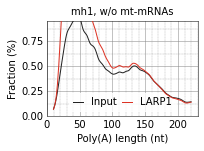

In [70]:
# Configurations
gene_subset = None 
subset_label = None
drop_subsets=['mtgenes']

savefig = True
minifig = True
# figsize = 5.4, 2.8 # for Fig. 4
figsize = 5.4, 3.5 # for Fig. 4

smoothing = True
smoothing_window = 15
pAlen_range = [10, 220]; pr = pAlen_range

styles = ["../polya.mplstyle"]
if minifig is True:
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))
    
with plt.style.context(styles):
    default_colors = sns.color_palette()
    colors_by_smp = json.load(open("../colors_by_smp.json","r"))
    colors = [colors_by_smp.get(smp, default_colors[si]) for si, smp in enumerate(samples)]
    global_fmax = None # Maximum value of the fraction
    
    fig, ax = plt.subplots(figsize=figsize)
    for si, smp in enumerate(samples):
        pn = panels[smp]
        
        # Consider only a specific gene set
        if gene_subset is not None:
            pn = pn.reindex(gene_subset) 

        # Exlucde specific gene sets
        if drop_subsets:
            for subset in drop_subsets:
                pn = pn.drop(gene_lists[subset], errors='ignore')

        if not pAlen_range: pAlen_range = [0, pn.shape[1]-1]

        # Normalization
        pAtags = pn.sum(axis=0).sum(axis=1).iloc[pr[0]:pr[1]+1]
        pAlen_dist = pAtags / pAtags.sum() * 100 # fraction in percent
        pAlen_dist = pAlen_dist * (mtnormed_tagcnts_sum[smp] / mtnormed_tagcnts_sum[ctrl])

        # Smoothing
        if smoothing is True:
            pAlen_dist = smooth(np.array(pAlen_dist), window_len=smoothing_window)

        fmax = pAlen_dist.max()
        if global_fmax is None: global_fmax = fmax
        elif global_fmax < fmax: global_fmax = fmax

        if smp == 'siLARP4_5': label = 'siLARP4/4B'
        elif smp == 'siLARP1-3': label = 'siLARP1'
        else: label = smp

        ## Plotting
        ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, color=colors[si], label=label, zorder=7)

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2)) 
    ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.set_xlim([0,230])
    ax.set_xticks(np.arange(0,230,50))
    # ax.set_ylim([0, np.round(global_fmax * 1.1, 1)])
    ax.set_ylim([0, 0.95])
    ax.legend(loc="lower center", fontsize="medium", ncol=2, handlelength=1.0, columnspacing=0.5)
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_ylabel("Fraction (%)")
    title = f"{work}, w/o mt-mRNAs"
    ax.set_title(title, fontsize="medium")

    fname_adduct = ""
    if gene_subset is not None: fname_adduct += f"_{subset_label}"
    if 'mtgenes' in drop_subsets: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = workdir/work/"plots/global_pAlen_dists_{}_mt-scaled_{}-{}{}.pdf".format(work, pr[0], pr[1], fname_adduct)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
        print(outfigpath, "saved")

    plt.show()

---
### Heat map for the poly(A) length histogram

In [71]:
# Additional imports
from polya.utils import binning
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [72]:
# Binning and counting poly(A) tas and get fractions for each bin

pAlen_range = (10, 220)
drop_mtgenes = True
scale = "linear"
binsize = 20
pseudocount = 1
edges = binning(pAlen_range[0], pAlen_range[1], binsize, cap=True)

# pAtag_cutoff = 100
pAtag_cutoff = 150

dfs = {}
for smp in samples:
    pn = panels[smp].drop(mtgenes, errors="ignore") if drop_mtgenes else panels[smp]

    df_polyA = pn.sum(axis=2).T.iloc[:, pAlen_range[0]:pAlen_range[1] + 1]
    b = np.digitize(df_polyA.columns, edges) - 1
    b[-1] -= 1 # To include the rightmost bound
    df_polyA.loc["bin"] = b
    df_binned = df_polyA.T.groupby("bin").agg(np.sum).T
    
    if pAtag_cutoff is not None:
        df_binned = df_binned[df_binned.sum(axis=1) >= pAtag_cutoff]
        
    df_binned += pseudocount
    df_binned_frac = df_binned.div(df_binned.sum(axis=1), axis="index")

    dfs[smp] = df_binned_frac
    print(smp, len(df_binned_frac))



Input 1997
LARP1 1726


In [73]:
# Cluster genes based on the pAlen histogram of ctrl sample

method = "kmeans"

df_frac_ctrl = dfs[ctrl].copy()

if method == "kmeans":
    nclusters = 5
    renumbering = True
    np.random.seed(42)
    est = KMeans(n_clusters=nclusters)
    est.fit(df_frac_ctrl)
    clusters = est.labels_
    
    if renumbering is True:    
        glstats_path = workdir/work/"stats/genelevelstats-GRCh38-single.csv"
        df_glstats = pd.read_csv(glstats_path, index_col=0)
        df_tmp = df_glstats.loc[df_frac_ctrl.index, [f"{ctrl}:polyA_mean"]].copy()
        df_tmp['cluster'] = clusters
        cluster_order = df_tmp.groupby('cluster').agg(np.mean).sort_values(by=df_tmp.columns[0]).index
        cluster_mappings = dict(zip(cluster_order, range(nclusters)))
        clusters = np.vectorize(cluster_mappings.get)(clusters)
        
    df_tmp = df_frac_ctrl.copy()
    df_tmp['cluster'] = clusters
    df_cluster = df_tmp.sort_values(by='cluster')
    cluster_counts = df_cluster['cluster'].value_counts()

    reordering_indices = df_cluster.index

elif method == "hierarchical":
    X = np.array(df_frac_ctrl)
    Z = linkage(X, "ward")
    D = dendrogram(Z)
    
    reordering_indices = df_frac_ctrl.iloc[D['ivl']].index

/casa/joha/projects/polya/works/mh1/plots/heatmap_binned_pAlen_hist_Input_kmeans_clustered.pdf saved


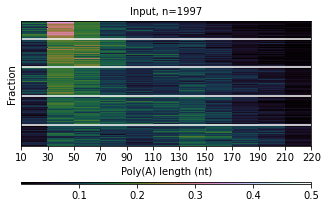

In [77]:
savefig = True
vmax = 0.5
figsize = 5.2, 3
fig, ax = plt.subplots(figsize=figsize)
image = ax.pcolor(df_frac_ctrl.reindex(reordering_indices).dropna().iloc[:,:], cmap='cubehelix', vmax=vmax, rasterized=True)
xticklabels = edges
ax.set_xticks(np.arange(len(xticklabels)))
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Poly(A) length (nt)')
ax.set_yticks([])
ax.set_ylabel(f'Fraction')

if method == "kmeans":
    # Draw horizontal lines that border clusters
    ncum = 0
    for ci in range(nclusters - 1):
        ncum += cluster_counts.loc[ci]
        ax.axhline(ncum, color="white")

ax.invert_yaxis()
    
# Adjust a colorbar
# create an axes on the right side of ax. The width of cax will be (size)%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1.5%", pad=0.5)
cbar = plt.colorbar(image, cax=cax, orientation="horizontal")
cbar.solids.set_rasterized(True)
ax.set_title(f"{ctrl.split('-')[0]}, n={len(df_frac_ctrl)}", fontsize='medium')

if savefig is True:
    outfigpath = workdir/work/f"plots/heatmap_binned_pAlen_hist_{ctrl}_{method}_clustered.pdf" 
    print(outfigpath, 'saved')
    plt.savefig(outfigpath, dpi=300, bbox_inches='tight')
    
plt.show()


/casa/joha/projects/polya/works/mh1/plots/heatmap_fraction_fold_mh1_LARP1_over_Input_reordered.pdf saved


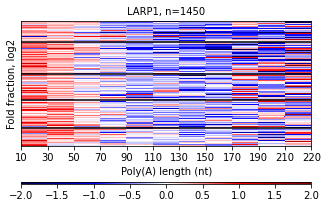

In [75]:
gene_subset = reordering_indices
subset_label = 'reordered'

savefig = True
figsize = 5.2, 3

df_frac_ctrl = dfs[ctrl]
for smp in dfs:
    if smp == ctrl: continue
    df_frac = dfs[smp].copy()
    df_fold = np.log2(df_frac.div(df_frac_ctrl, axis='index').dropna())
    
    if gene_subset is not None:
        df_fold = df_fold.reindex(gene_subset).dropna()
        
    fig, ax = plt.subplots(figsize=figsize)
    cmap = 'seismic'
    image = ax.pcolor(df_fold.iloc[:,:], vmin=-2, vmax=2, cmap=cmap, rasterized=True)
    
    if method == "kmeans":
        # Draw horizontal lines that border clusters
        ncum = 0
        cc = df_cluster['cluster'].reindex(df_fold.index).value_counts()
        for ci in range(nclusters - 1):
            ncum += cc.loc[ci]
            ax.axhline(ncum, color="black")
        
    # Adjust x-axis
    # xticklabels = edges + [pAlen_range[1]]
    xticklabels = edges
    ax.set_xticks(np.arange(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Poly(A) length (nt)')

    # Adjust y-axis
    ax.set_yticks([])
    ax.set_ylabel(f'Fold fraction, log2')
    ax.invert_yaxis()
    
    # Adjust a colorbar
    # create an axes on the right side of ax. The width of cax will be (size)%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="1.5%", pad=0.5)
    cbar = plt.colorbar(image, cax=cax, orientation="horizontal")
    cbar.solids.set_rasterized(True)
    
    ax.set_title(f"{smp.split('-')[0]}, n={len(df_fold)}", fontsize='medium')
    
    fname_adduct = ""
    if gene_subset is not None: fname_adduct += f"_{subset_label}"
    
    if savefig is True:
        outfigpath = workdir/work/"plots/heatmap_fraction_fold_{}_{}_over_{}{}.pdf".format(work, smp, ctrl, fname_adduct)
        plt.savefig(outfigpath, dpi=300, bbox_inches='tight')
        print(outfigpath, 'saved')
        
    plt.show()


Metagene-level poly(A) length distributions by clusters

/casa/joha/projects/polya/works/mh1/plots/clusters_pAlen_dists_mh1_10-220_mini.pdf saved


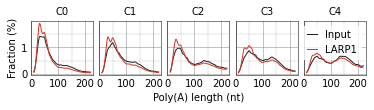

In [76]:
savefig = True
minifig = True
figsize = 12, 2

smoothing = True
smoothing_window = 15
pAlen_range = [10, 220]; pr = pAlen_range


styles = ["../polya.mplstyle"]
if minifig is True:
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))
    
with plt.style.context(styles):
    default_colors = sns.color_palette()
    colors_by_smp = json.load(open("../colors_by_smp.json","r"))
    colors = [colors_by_smp.get(smp, default_colors[si]) for si, smp in enumerate(samples)]
    global_fmax = 0
    
    fig, axes = plt.subplots(1, len(cluster_counts), sharey=True, figsize=figsize,
                             gridspec_kw=dict(wspace=0.1))
    for clstr, group in df_cluster.groupby('cluster'):
        gids = group.index
        ax = axes[clstr]
        for si, smp in enumerate(samples):
            pn = panels[smp].reindex(gids)

            if not pAlen_range: pAlen_range = [0, pn.shape[1]-1]

            # Normalization
            pAtags = pn.sum(axis=0).sum(axis=1).iloc[pr[0]:pr[1]+1]
            pAlen_dist = pAtags / pAtags.sum() * 100 # fraction in percent

            # Smoothing
            if smoothing is True:
                pAlen_dist = smooth(np.array(pAlen_dist), window_len=smoothing_window)

            fmax = pAlen_dist.max()
            if global_fmax is None: global_fmax = fmax
            elif global_fmax < fmax: global_fmax = fmax

            if smp == 'siLARP4_5': label = 'siLARP4/4B'
            elif smp == 'siLARP44B': label = 'siLARP4/4B'
            elif smp == 'siLARP1-3': label = 'siLARP1'
            else: label = smp

            # Plotting
            ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, color=colors[si], label=label, zorder=7)
            
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2)) 
        ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
        ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
        ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
        ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
        ax.set_xlim([0,230])
        ax.set_xticks(np.arange(0,230,100))
        ax.set_title(f"C{clstr}", fontsize='medium')
        
    axes[0].set_ylabel("Fraction (%)")
    axes[2].set_xlabel("Poly(A) length (nt)")
    axes[-1].legend(loc="upper right", fontsize="medium", ncol=1, handlelength=1.0, columnspacing=0.5)

    fname_adduct = ""
    if minifig is True: fname_adduct += "_mini"
    
    if savefig is True:
        outfigpath = workdir/work/"plots/clusters_pAlen_dists_{}_{}-{}{}.pdf".format(work, pr[0], pr[1], fname_adduct)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
        print(outfigpath, "saved")
            
    plt.show()